In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def show_image(image, label):
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.title(label)
    plt.show()

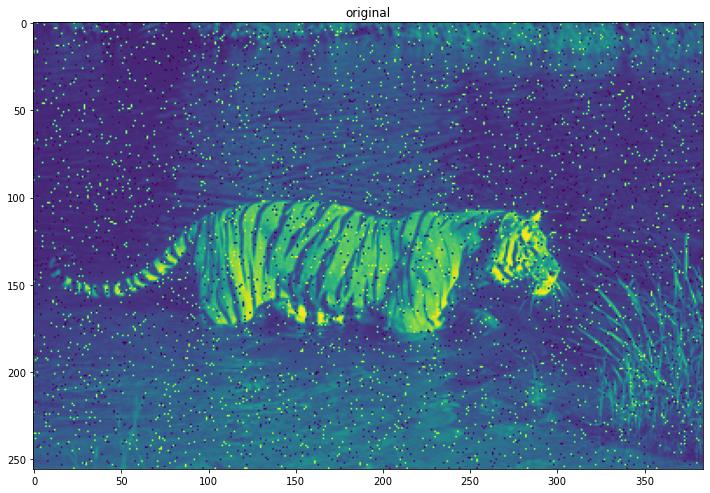

In [3]:
image = cv.cvtColor(cv.imread("ex1.png"), cv.COLOR_BGR2GRAY)
show_image(image, 'original')

# Медианный фильтр

## Наивная реализация

In [4]:
from itertools import product

import numpy as np

In [5]:
def median_filter_sort(image, R):
    height, width = image.shape
    result = image.copy()
    R_half = R // 2
    for i, j in product(range(height), range(width)):
        result[i, j] = np.median(image[max(0, i - R_half):min(height, i + R_half + 1),
                                       max(0, j - R_half):min(width, j + R_half + 1)])
    return result

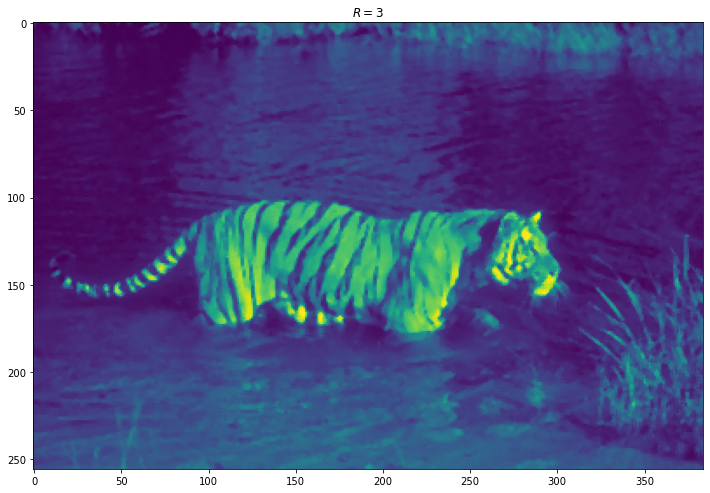

In [7]:
R = 3
naive_result = median_filter_sort(image, R)
show_image(naive_result, fr'$R = {R}$')

## Алгоритм Huang

In [32]:
def get_median_hist(hist, hist_size):
    current = 0
    half_size = hist_size // 2
    if hist_size % 2 == 1:
        for k in range(256):
            if hist[k] == 0:
                continue
            current += hist[k]
            if current > half_size:
                return k
    else:
        left_middle = None
        for k in range(256):
            if hist[k] == 0:
                continue
            current += hist[k]
            if current > half_size:
                if left_middle is None:
                    return k
                else:
                    return (left_middle + k) // 2
            if current == half_size:
                left_middle = k


In [33]:
def median_filter_huang(image, R):
    height, width = image.shape
    result = image.copy()
    R_half = R // 2
    for i in range(height):
        part = image[max(0, i - R_half):min(height, i + R_half + 1), 0:R_half + 1]
        hist_size = part.size
        hist = np.histogram(part, bins=np.arange(257))[0]
        result[i, 0] = get_median_hist(hist, hist_size)
        for j in range(1, width):
            for k in range(-R_half, R_half + 1):
                if i + k < 0 or i + k >= height:
                    continue
                if j - R_half - 1 >= 0:
                    hist[image[i + k, j - R_half - 1]] -= 1
                    hist_size -= 1
                if j + R_half < width:
                    hist[image[i + k, j + R_half]] += 1
                    hist_size += 1
            
            result[i, j] = get_median_hist(hist, hist_size)
    
    return result

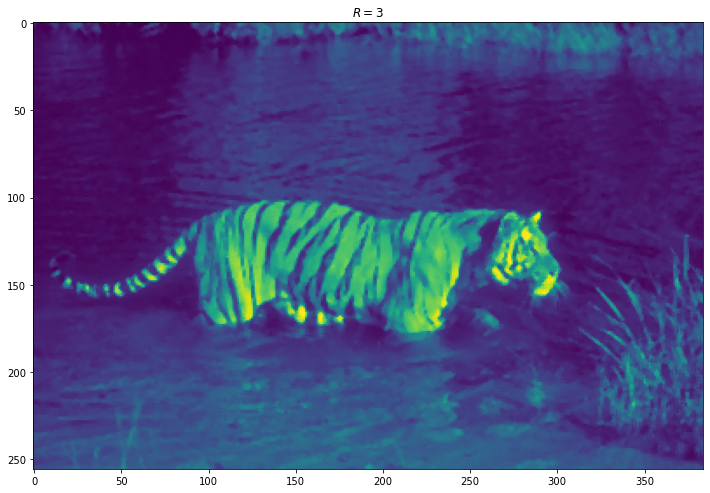

In [24]:
R = 3
huang_result = median_filter_huang(image, R)
show_image(huang_result, fr'$R = {R}$')

In [25]:
assert np.linalg.norm(naive_result - huang_result) == 0

## Оптимизированный алгоритм Huang

In [58]:
def median_filter_optimized_huang(image, R):
    height, width = image.shape
    result = image.copy()
    R_half = R // 2
    column_hist = []
    column_size = []
    hist_size = 0
    
    for i in range(width):
        column_hist.append(np.histogram(image[0:R_half + 1, i:i + 1], bins=np.arange(257))[0])
        column_size.append(R_half + 1)

    hist = np.zeros(256)
    for r in range(R_half + 1):
        hist += column_hist[r]
        hist_size += column_size[r]
    
    result[0, 0] = get_median_hist(hist, hist_size)
    for j in range(1, width):
        remove = 0
        add = 0
        
        if j - R_half - 1 >= 0:
            remove = column_hist[j - R_half - 1]
            hist_size -= column_size[j - R_half - 1]
        if j + R_half < width:
            add = column_hist[j + R_half]
            hist_size += column_size[j + R_half]
        
        hist += add - remove
        result[0, j] = get_median_hist(hist, hist_size)
    
    for i in range(1, height):
        hist = np.zeros(256)
        hist_size = 0
        for r in range(R_half + 1):
            if i - R_half - 1 >= 0:
                column_hist[r][image[i - R_half - 1, r]] -= 1
                column_size[r] -= 1
            if i + R_half < height:
                column_hist[r][image[i + R_half, r]] += 1
                column_size[r] += 1
            hist += column_hist[r]
            hist_size += column_size[r]
        result[i, 0] = get_median_hist(hist, hist_size)
        
        for j in range(1, width):
            remove = 0
            add = 0
            if j + R_half < width:
                if i - R_half - 1 >= 0:
                    column_hist[j + R_half][image[i - R_half - 1, j + R_half]] -= 1
                    column_size[j + R_half] -= 1
                if i + R_half < height:
                    column_hist[j + R_half][image[i + R_half, j + R_half]] += 1
                    column_size[j + R_half] += 1
                add = column_hist[j + R_half]
                hist_size += column_size[j + R_half]
            if j - R_half - 1 >= 0:
                remove = column_hist[j - R_half - 1]
                hist_size -= column_size[j - R_half - 1]
            
            hist += add - remove
            result[i, j] = get_median_hist(hist, hist_size)
#             print(f'add: {add}')
#             print(f'remove: {remove}')
#             print(f'hist: {hist}')
#             print(f'hist_size: {hist_size}')
#             print(f'median: {result[i, j]}')

    return result

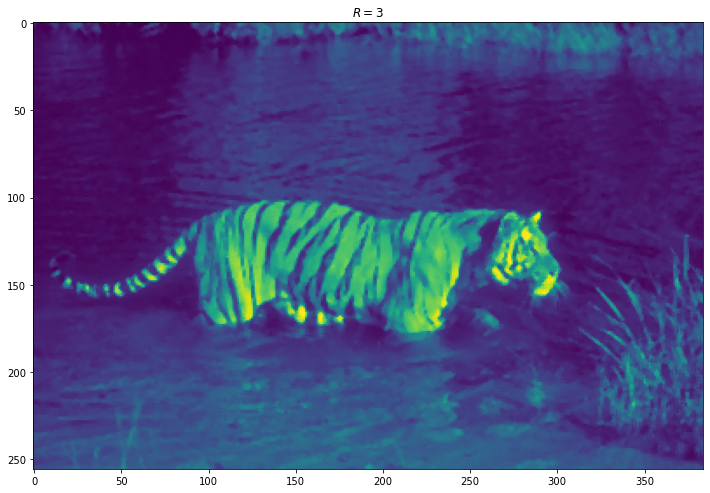

In [59]:
R = 3
optimized_huang_result = median_filter_optimized_huang(image, R)
show_image(optimized_huang_result, fr'$R = {R}$')

In [60]:
assert np.linalg.norm(optimized_huang_result - naive_result) == 0

# Бенчмарки

In [66]:
from time import time

from tqdm import tqdm

In [63]:
def measure_time(algorithm, image, R):
    start = time()
    algorithm(image, R)
    return time() - start

In [67]:
naive_time = []
huang_time = []
optimized_huang_time = []

R_grid = np.arange(3, 100, 2)
for R in tqdm(R_grid):
    naive_time.append(measure_time(median_filter_sort, image, R))
    huang_time.append(measure_time(median_filter_huang, image, R))
    optimized_huang_time.append(measure_time(median_filter_optimized_huang, image, R))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [15:52<00:00, 19.44s/it]


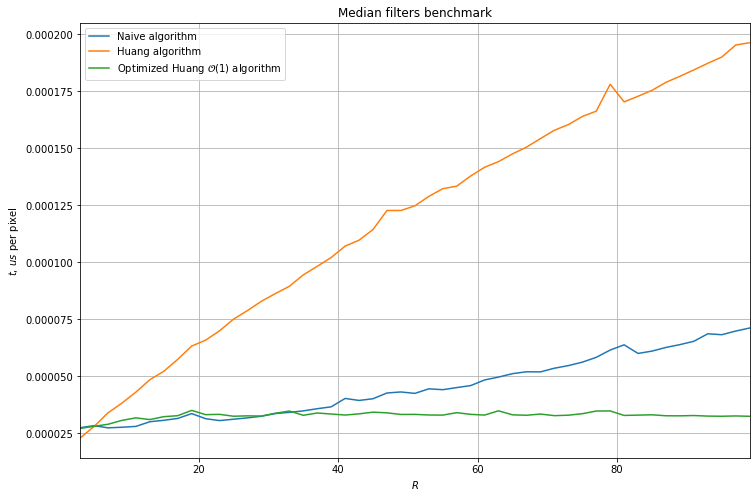

In [82]:
plt.figure(figsize=(12, 8))
plt.plot(R_grid, np.array(naive_time) / image.size, label='Naive algorithm')
plt.plot(R_grid, np.array(huang_time) / image.size, label='Huang algorithm')
plt.plot(R_grid, np.array(optimized_huang_time) / image.size, label=r'Optimized Huang $\mathcal{O}(1)$ algorithm')
plt.grid()
plt.legend()
plt.xlim(R_grid.min(), R_grid.max())
plt.title(r'Median filters benchmark')
plt.xlabel(r'$R$')
plt.ylabel(r'$t$, $us$ per pixel')
plt.show()

Видим, что Huang в теории, конечно, хорош, но константа огромная, из-за чего он работает хуже хорошо векторизуемого наивного алгоритма

В то же время его оптимизированная версия работает действительно быстрее наивного алгоритма, время даже почти не зависит от $R$